In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/NLPPROJECT/Reviews.csv')  # Adjust if path changes

# Display basic info
df.shape, df.columns, df.head()


((568454, 10),
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
        'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
       dtype='object'),
    Id   ProductId          UserId                      ProfileName  \
 0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
 1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
 2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
 3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
 4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
 
    HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
 0                     1                       1      5  1303862400   
 1                     0                       0      1  1346976000   
 2                     1                       1      4  1219017600   
 3                     3                       3      2  1307923200   
 4                     0       

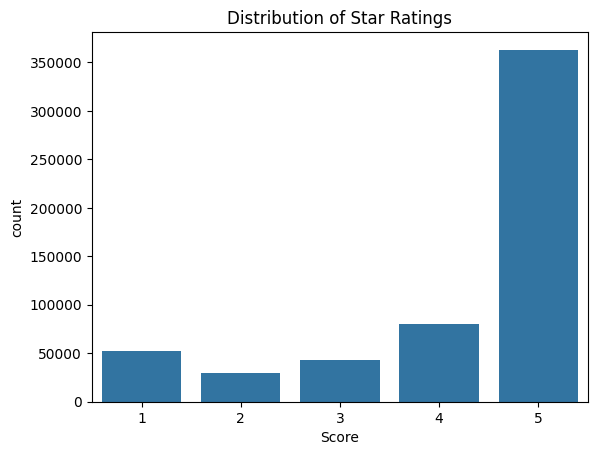

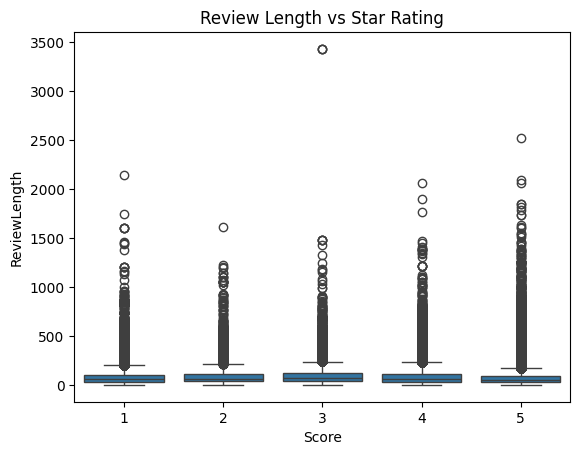

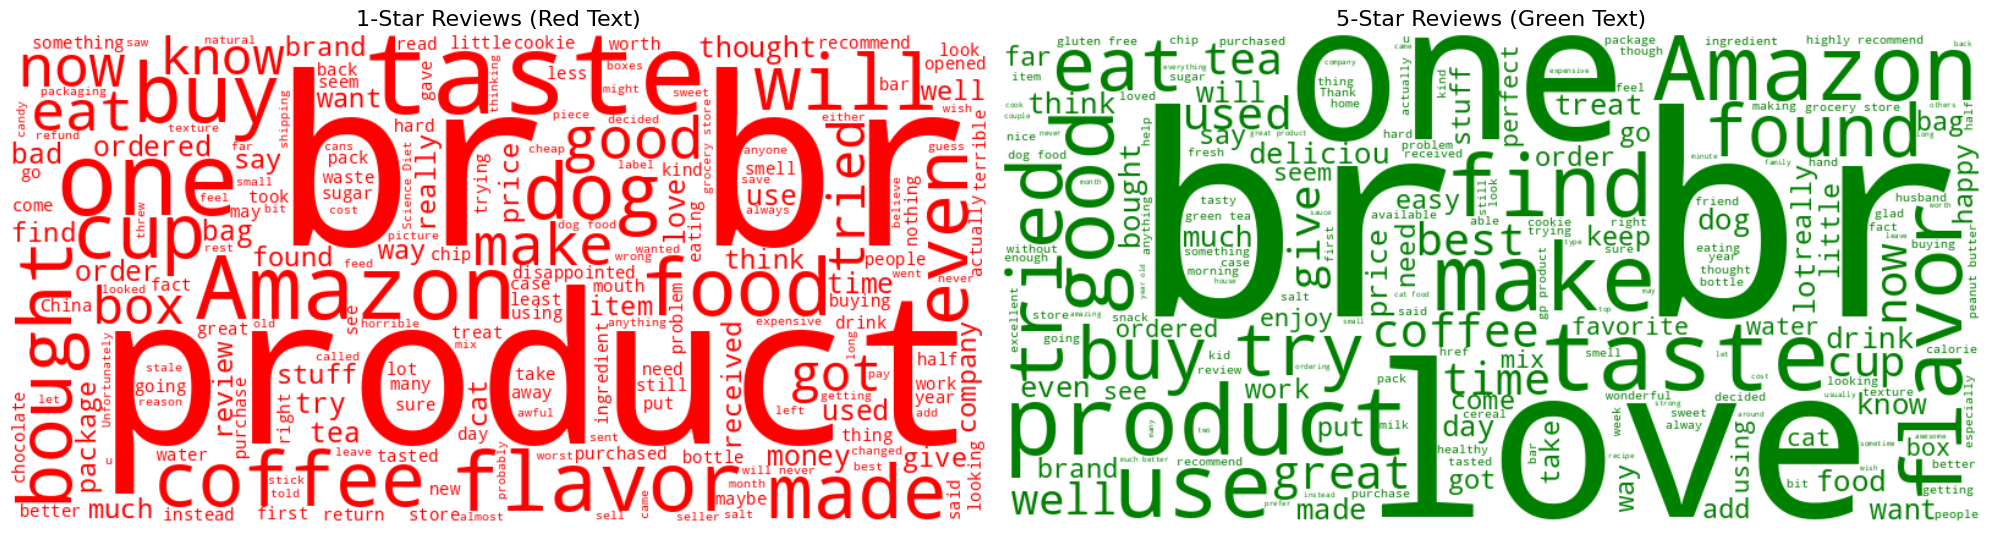

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd

# Remove 'BR' from text
df['CleanText'] = df['Text'].astype(str).str.replace(r'\bBR\b', '', regex=True)

# Distribution of star ratings
sns.countplot(x='Score', data=df)
plt.title('Distribution of Star Ratings')
plt.show()

# Review length vs rating
df['ReviewLength'] = df['CleanText'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='Score', y='ReviewLength', data=df)
plt.title('Review Length vs Star Rating')
plt.show()

# Function to generate a single word cloud
def generate_wordcloud(score, color='black'):
    text = ' '.join(df[df['Score'] == score]['CleanText'])
    wc = WordCloud(width=800, height=400, background_color='white', color_func=lambda *args, **kwargs: color).generate(text)
    return wc

# Side-by-side word clouds with color-coded sentiment
wc_positive = generate_wordcloud(5, color='green')
wc_negative = generate_wordcloud(1, color='red')

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(wc_negative, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("1-Star Reviews (Red Text)", fontsize=16)

axes[1].imshow(wc_positive, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("5-Star Reviews (Green Text)", fontsize=16)

plt.tight_layout()
plt.show()


In [3]:
!pip install -U spacy textblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.6
    Uninstalling spacy-3.8.6:
      Successfully uninstalled spacy-3.8.6
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 104.1 MB/s eta 0:00:00
✔ Do

In [3]:
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

nlp = spacy.load('en_core_web_sm')


In [4]:
import re
import pandas as pd
import spacy
from tqdm import tqdm

tqdm.pandas()
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # Only use tagger for lemmatization

# Clean text (remove punctuation/digits, lowercase, remove extra spaces)
def clean_text(text):
    return re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z]', ' ', str(text).lower())).strip()

# Apply fast cleaning
df['CleanText'] = df['Text'].progress_apply(clean_text)

# Fast batch lemmatization using spacy.pipe()
def batch_lemmatize(texts, batch_size=500):
    lemmatized = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts), desc="Lemmatizing"):
        lemmatized.append(' '.join([token.lemma_ for token in doc if not token.is_stop]))
    return lemmatized

# Apply to cleaned text
df['LemmatizedText'] = batch_lemmatize(df['CleanText'].tolist())


Lemmatizing: 100%|██████████| 568454/568454 [54:53<00:00, 172.59it/s]


In [19]:

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_tfidf = tfidf.fit_transform(df['LemmatizedText'])
from textblob import TextBlob  # <-- Add this line

# Compute sentiment polarity from lemmatized text
df['Sentiment'] = df['LemmatizedText'].apply(lambda x: TextBlob(x).sentiment.polarity)

import scipy.sparse
from sklearn.preprocessing import MinMaxScaler

# Normalize sentiment scores
sentiment_scaled = MinMaxScaler().fit_transform(df[['Sentiment']])
sentiment_sparse = scipy.sparse.csr_matrix(sentiment_scaled)

# Combine TF-IDF + Sentiment
X = scipy.sparse.hstack((X_tfidf, sentiment_sparse))


In [6]:
# We’ll only keep reviews with ratings 1, 2, 3, 4, 5
df = df[df['Score'].isin([1, 2, 3, 4, 5])]

y = df['Score']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression (one-vs-rest)
lr = LogisticRegression(max_iter=1000, multi_class='ovr')
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

print("📊 Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))





/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


📊 Logistic Regression Performance:
              precision    recall  f1-score   support

           1       0.66      0.66      0.66      7840
           2       0.53      0.18      0.27      4466
           3       0.51      0.25      0.34      6396
           4       0.51      0.24      0.33     12098
           5       0.78      0.96      0.86     54469

    accuracy                           0.74     85269
   macro avg       0.60      0.46      0.49     85269
weighted avg       0.70      0.74      0.70     85269

Confusion Matrix:
 [[ 5184   300   279   194  1883]
 [ 1191   811   575   370  1519]
 [  646   270  1620  1015  2845]
 [  295    78   450  2891  8384]
 [  523    64   255  1201 52426]]


In [9]:
# Shift labels: [1,2,3,4,5] → [0,1,2,3,4]
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1


In [10]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
xgb.fit(X_train, y_train_xgb)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb += 1  # Shift back to original labels for evaluation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
print("📊 XGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


📊 XGBoost Classifier Performance:
              precision    recall  f1-score   support

           1       0.66      0.58      0.62      7840
           2       0.65      0.20      0.30      4466
           3       0.62      0.23      0.33      6396
           4       0.61      0.20      0.30     12098
           5       0.75      0.98      0.85     54469

    accuracy                           0.73     85269
   macro avg       0.66      0.44      0.48     85269
weighted avg       0.71      0.73      0.68     85269

Confusion Matrix:
 [[ 4552   220   164    99  2805]
 [  945   882   317   231  2091]
 [  591   158  1462   599  3586]
 [  284    52   276  2367  9119]
 [  548    43   140   588 53150]]


In [12]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize output for AUC calculation (multiclass)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_proba_lr = lr.predict_proba(X_test)
y_proba_xgb = xgb.predict_proba(X_test)

auc_lr = roc_auc_score(y_test_bin, y_proba_lr, average='macro', multi_class='ovr')
auc_xgb = roc_auc_score(y_test_bin, y_proba_xgb, average='macro', multi_class='ovr')

print("ROC AUC (Logistic Regression):", auc_lr)
print("ROC AUC (XGBoost):", auc_xgb)


ROC AUC (Logistic Regression): 0.8746444588151616
ROC AUC (XGBoost): 0.8645560608290502


In [13]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Logistic Regression
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Macro F1 Score:", f1_score(y_test, y_pred_lr, average='macro'))

# XGBoost
print("\nXGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Macro F1 Score:", f1_score(y_test, y_pred_xgb, average='macro'))


Logistic Regression Metrics:
Accuracy: 0.7380407885632527
Macro F1 Score: 0.49173413528414506

XGBoost Metrics:
Accuracy: 0.7319541685724003
Macro F1 Score: 0.47978752500686667


In [14]:
# Shift star ratings
y_train_adj = y_train - 1
y_test_adj = y_test - 1


In [15]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression hyperparameter tuning example
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # 'l1' needs solver='liblinear' (not compatible with multi_class='ovr' default)
    'solver': ['lbfgs'],
    'max_iter': [500, 1000]
}

grid_lr = GridSearchCV(LogisticRegression(multi_class='ovr'), param_grid_lr, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# Evaluate tuned Logistic Regression
y_pred_lr_tuned = best_lr.predict(X_test)
print("Tuned Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr_tuned))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Logistic Regression params: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuned Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.68      0.67      7840
           2       0.52      0.24      0.33      4466
           3       0.50      0.29      0.37      6396
           4       0.51      0.26      0.35     12098
           5       0.80      0.95      0.87     54469

    accuracy                           0.74     85269
   macro avg       0.60      0.49      0.52     85269
weighted avg       0.71      0.74      0.71     85269



Accuracy: 0.7319541685724003
Macro F1 Score: 0.47978752500686667

Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.58      0.62      7840
           2       0.65      0.20      0.30      4466
           3       0.62      0.23      0.33      6396
           4       0.61      0.20      0.30     12098
           5       0.75      0.98      0.85     54469

    accuracy                           0.73     85269
   macro avg       0.66      0.44      0.48     85269
weighted avg       0.71      0.73      0.68     85269



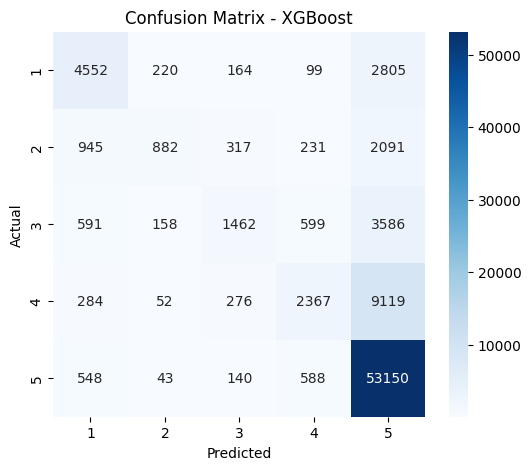

ROC AUC Score (macro, multiclass): 0.8645560608290502


In [17]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Predict and shift back
y_pred_xgb = xgb.predict(X_test) + 1

# Accuracy and F1
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Macro F1 Score:", f1_score(y_test, y_pred_xgb, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC (multiclass)
y_test_bin = label_binarize(y_test, classes=[1,2,3,4,5])
y_proba_xgb = xgb.predict_proba(X_test)
auc_xgb = roc_auc_score(y_test_bin, y_proba_xgb, average='macro', multi_class='ovr')
print("ROC AUC Score (macro, multiclass):", auc_xgb)


In [26]:
!ls -lh /content/tfidf_vectorizer.pkl /content/xgboost_model.pkl


-rw-r--r-- 1 root root    0 Jun  1 18:40 /content/tfidf_vectorizer.pkl
-rw-r--r-- 1 root root 1.6M Jun  1 18:38 /content/xgboost_model.pkl


In [29]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Load your dataset (use your actual CSV file path)
  # adjust if needed
texts = df['Text'].fillna("")  # Avoid NaNs

# Optional: define a preprocessing function (like lemmatization) if you had one
# For now, use plain lowercase text
texts_cleaned = texts.str.lower()

# Step 2: Fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(texts_cleaned)

# Step 3: Save the vectorizer
with open("/content/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [31]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(df['Text'].fillna("").str.lower())

with open("/content/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Adjust labels (assuming 1–5 star ratings in 'Score' column)
y = df['Score'] - 1  # Shift to 0–4

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Save model
with open("/content/xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [34]:
import pickle

# Load
with open("/content/tfidf_vectorizer.pkl", "rb") as f:
    loaded_vectorizer = pickle.load(f)

with open("/content/xgboost_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Predict
sample_review = ["The food was stale and packaging was poor."]
sample_review_cleaned = [r.lower() for r in sample_review]

X_new = loaded_vectorizer.transform(sample_review_cleaned)
pred = loaded_model.predict(X_new) + 1  # back to 1–5

print("⭐ Predicted Star Rating:", pred[0])


⭐ Predicted Star Rating: 1
